### Задачи к Лекции 5

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,1,0,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0,0,1,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,1,0,0,0


## Задачи

__1. Хоть в sklearn и присутствует реализация метода k-ближайших соседей, я же предлагаю попробовать вам написать его самостоятельно.__

* __создать классификатор используя только pandas, numpy и scipy. Гиперпараметром данного классификатора должно быть число ближайших соседей. (Необязательно) можно добавить метрику расстояния и выбор весов.__
* __С помощью кросс-валидации найти оптимальное количество ближайших соседей и (необязательно) набор признаков.__

Алгоритм работы классификатора:
 1. Для заданного прецедент  $\vec{x}$ мы считаем расстояние до всех прецедентов в обучающей выборке.
 2. Сортируем прецеденты по расстоянию до $\vec{x}$.
 3. Отбираем $k$ минимальных значений
 4. Устраиваем голосование между отобранными прецедент.

In [2]:
class SimpleKnn:
    """
        Простейшая реализация kNN. Довольно медленно работает на больших объемах данных.
    """
    def __init__(self, k): 
        self.k = k
        self.data = None
        
        # Это нам понадобиться для масштабирования новых данных
        self.means = None
        self.stds = None
        
        self.target = None
        
    def set_k(self, k):
        self.k = k
    
    def fit(self, X, Y):
        """
            Принимаем только массивы от numpy
        """
        if not isinstance(X, np.ndarray) or not isinstance(Y, np.ndarray):
            raise Exception("Invalid array")
        
        if X.shape[0] != Y.shape[0]:
            raise Exception("Invalid shapes")
        
        if len(Y.shape) > 1:
            raise Exception("Invalid target shape")
            
        # Нормализуем данные
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)   
        
        self.data = (X - self.means) / self.stds
        self.target = Y
    
    def _predict(self, row):
        # считаем обычное расстояние 
        distances = np.sum((self.data - row)**2, axis=1)  
        
        # Находим индексы отсортированного массива
        idx = np.argsort(distances)
        
        # и смотрим k первых                
        vote = 0
        for i in idx[:self.k]:
            vote += 1 if self.target[i] else -1
        if vote >= 0:
            return 1
        else:
            return 0
        
    
    def predict(self, X):
        # Сразу же нормируем
        X = (X - self.means) / self.stds
        
        results = np.zeros(X.shape[0])
        for i, row in enumerate(X):
            results[i] = self._predict(row)
            
        return results

In [3]:
from sklearn.model_selection import train_test_split

# Убираем последний столбец в данных для анализа
data = df.drop('cardio', axis=1).values

# Наши исходы
target = df['cardio'].values

data_train, data_test, target_train, target_test = train_test_split(   
    data, target, 
    test_size=0.3,
)

Проверим, что он работает

In [4]:
knn = SimpleKnn(5)
knn.fit(data_train, target_train)
print("Predict = %d\nTarget = %d" % (knn._predict(data_test[0]), target_test[0]))

Predict = 1
Target = 0


In [9]:
%%time

from sklearn.metrics import accuracy_score

knn = SimpleKnn(5)
knn.fit(data_train, target_train)

# Ограничиваем выборку, т.к. наивная реализация будет работать крайне медленно
N = 2000
print("Accuracy = %f" % (accuracy_score(target_test[:N], knn.predict(data_test[:N]))))

Accuracy = 0.658000
CPU times: user 24.6 s, sys: 0 ns, total: 24.6 s
Wall time: 24.9 s


Возьмем за эталон оптимизированный класс из sklearn

In [8]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(5))
pipe.fit(data_train, target_train)
cv = pipe.predict(data_test)
accuracy_score(target_test, cv)

CPU times: user 16.2 s, sys: 0 ns, total: 16.2 s
Wall time: 16.3 s


0.6530476190476191

А теперь найдем оптимальное количество соседей.

In [10]:
%%time

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

knn = SimpleKnn(1)

# Просто создаю генератор фолдов
kf = KFold(n_splits=2, random_state=13)
#kf = StratifiedKFold(n_splits=2, random_state=13)

K = np.arange(1, 100, 1)
acc = np.zeros(K.shape)
f1 = np.zeros(K.shape)

for train_index, test_index in kf.split(data[:5000], target[:5000]):
    data_train, data_test = data[train_index], data[test_index]
    target_train, target_test = target[train_index], target[test_index]

    knn.fit(data_train, target_train)
    
    for i, k in enumerate(K):
        knn.set_k(k)
        cv = knn.predict(data_test)        
        acc[i] += accuracy_score(target_test, cv)
        f1[i] += f1_score(target_test, cv)

acc = acc / kf.get_n_splits()
f1 = f1 / kf.get_n_splits()

CPU times: user 3min 34s, sys: 73.5 ms, total: 3min 34s
Wall time: 3min 35s


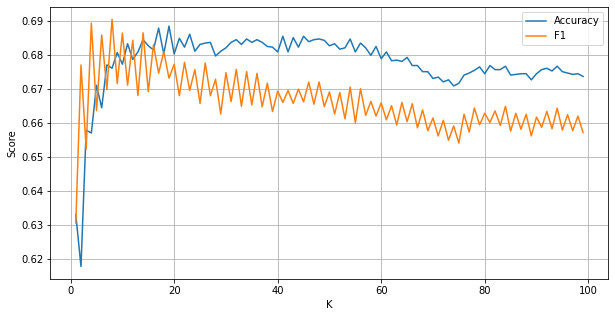

In [12]:
plt.figure(figsize=(10, 5))
plt.xlabel("K")
plt.ylabel("Score")
plt.plot(K, acc, label="Accuracy")
plt.plot(K, f1, label="F1")
plt.legend()
plt.grid()
plt.show()

**2. Определить какой из трех классификаторов (kNN, наивный Байес, решающее дерево) лучший в каждой метрике по отдельности: accuracy, F1-мера, ROC AUC. Использовать набор признаков: 'age', 'weight', 'height', 'ap_lo', 'ap_hi'.**

**(Необязательно) Найти оптимальный набор признаков.**

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


features = ['age', 'weight', 'height', 'ap_lo', 'ap_hi']

data= df[features].values
target = df['cardio'].values

classifiers = [
    ("NB", GaussianNB(), {}),
    ("Knn", make_pipeline(StandardScaler(), KNeighborsClassifier()),  {"kneighborsclassifier__n_neighbors": np.arange(7, 30, 2)}),
    ("Tree", DecisionTreeClassifier(), {"max_depth": np.arange(2, 10)}),
]

results = []
for name, classifier, params in classifiers:    
    print(name)
    grid_acc = GridSearchCV(
        classifier, params, scoring='accuracy',
        cv=3, refit=False,        
    )
    grid_acc.fit(data, target)
    print("\tAcc =", grid_acc.best_score_, grid_acc.best_params_)
    
    grid_f1 = GridSearchCV(
        classifier, params, scoring='f1',
        cv=3, refit=False,        
    )
    grid_f1.fit(data, target)
    print("\tF1 =", grid_f1.best_score_, grid_f1.best_params_)
    
    grid_roc = GridSearchCV(
        classifier, params, scoring='roc_auc',
        cv=3, refit=False,        
    )
    grid_roc.fit(data, target)
    print("\tROC AUC =", grid_roc.best_score_, grid_roc.best_params_)
    
    grid_logloss = GridSearchCV(
        classifier, params, scoring='neg_log_loss',
        cv=3, refit=False,        
    )
    grid_logloss.fit(data, target)
    print("\tLogloss =", grid_logloss.best_score_, grid_logloss.best_params_)
    
    results.append((name, grid_f1.best_score_, grid_acc.best_score_, grid_roc.best_score_, grid_logloss.best_score_))


print()    

dr = pd.DataFrame(results, columns=["Name", "F1", "Accuracy", "ROC AUC", "Logloss"])
print("Accuracy\n", dr.sort_values(by="Accuracy")[-1:])
print()
print("F1\n", dr.sort_values(by="F1")[-1:])
print()
print("ROC AUC\n", dr.sort_values(by="ROC AUC")[-1:])
print()
print("Logloss\n", dr.sort_values(by="Logloss")[-1:])
print()

dr

NB
	Acc = 0.5492570138994982 {}
	F1 = 0.24781958152674566 {}
	ROC AUC = 0.692788907876538 {}
	Logloss = -0.8605206726436455 {}
Knn
	Acc = 0.6831001141547365 {'kneighborsclassifier__n_neighbors': 23}
	F1 = 0.6697215910554557 {'kneighborsclassifier__n_neighbors': 23}
	ROC AUC = 0.7409622417371304 {'kneighborsclassifier__n_neighbors': 23}
	Logloss = -0.611003163302373 {'kneighborsclassifier__n_neighbors': 29}
Tree
	Acc = 0.72237145111085 {'max_depth': 5}
	F1 = 0.7147200622342039 {'max_depth': 4}
	ROC AUC = 0.7855646067778207 {'max_depth': 6}
	Logloss = -0.5593339428783105 {'max_depth': 4}

Accuracy
    Name       F1  Accuracy   ROC AUC   Logloss
2  Tree  0.71472  0.722371  0.785565 -0.559334

F1
    Name       F1  Accuracy   ROC AUC   Logloss
2  Tree  0.71472  0.722371  0.785565 -0.559334

ROC AUC
    Name       F1  Accuracy   ROC AUC   Logloss
2  Tree  0.71472  0.722371  0.785565 -0.559334

Logloss
    Name       F1  Accuracy   ROC AUC   Logloss
2  Tree  0.71472  0.722371  0.785565 -0.55

,Name,F1,Accuracy,ROC AUC,Logloss
0,NB,0.247820,0.549257,0.692789,-0.860521
1,Knn,0.669722,0.683100,0.740962,-0.611003
2,Tree,0.714720,0.722371,0.785565,-0.559334
